In [0]:
import os
PATH = os.getcwd()

print(PATH)

from google.colab import drive
drive.mount('/content/gdrive')

os.chdir("/content/gdrive/My Drive/Cute04")

/content
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
import os

from keras.preprocessing.text import Tokenizer,text_to_word_sequence
from keras.preprocessing import sequence
from keras.models import Sequential
from keras import layers
from keras.layers import Activation, Conv1D, Dense, Embedding, Flatten, Input, MaxPooling1D

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder


%matplotlib inline
import matplotlib.pyplot as plt

import re
import pandas as pd
import random
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

import numpy as np

Using TensorFlow backend.


# Import of train and test data

In [0]:
train_rawdata = pd.read_csv("train-1546603042473.csv")
test_rawdata = pd.read_csv("test3.csv")
print(train_rawdata.shape)
print(type(train_rawdata))
print(test_rawdata.shape)
print(type(test_rawdata))

(48699, 2)
<class 'pandas.core.frame.DataFrame'>
(8581, 2)
<class 'pandas.core.frame.DataFrame'>


# Data Exploration


In [0]:
train_rawdata.head()

,categories,converse
0,QUERIES FROM PHARMACY,please to verify instructions for drugname pat...
1,NEW APPOINTMENT,lmovm for patients mother to and schd rov trac...
2,OTHERS,labtype and insurance approval other incoming ...
3,OTHERS,clinical list changes medfusion secure electro...
4,MEDICATION RELATED,wants to wean off medication work phone name d...


## To check the frequency of different class of target variable

In [0]:
train_rawdata.categories.value_counts()

MEDICATION RELATED                               9010
NEW APPOINTMENT                                  8907
REFILL                                           8347
OTHERS                                           6253
SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)    3018
LAB RESULTS                                      2253
PROVIDER                                         1677
QUERIES FROM PHARMACY                            1464
RESCHEDULING                                     1383
SHARING OF LAB RECORDS (FAX, E-MAIL, ETC.)       1212
PRIOR AUTHORIZATION                              1043
SYMPTOMS                                         1021
CHANGE OF PROVIDER                                811
RUNNING LATE TO APPOINTMENT                       590
CANCELLATION                                      564
QUERY ON CURRENT APPOINTMENT                      559
FOLLOW UP ON PREVIOUS REQUEST                     304
CHANGE OF HOSPITAL                                127
QUERIES FROM INSURANCE FIRM 

# To remove the missing data from train data

In [0]:
train_rawdata1=train_rawdata[pd.notnull(train_rawdata['converse'])]

# To check the null value after deleting the missing rows

In [0]:
train_rawdata1.isnull().sum()

categories    0
converse      0
dtype: int64

In [0]:
target=train_rawdata1["categories"]


In [0]:
#target=target.map({'MEDICATION RELATED':0,'NEW APPOINTMENT':1,'REFILL':2,'OTHERS':3,'SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)':4,'LAB RESULTS':5,'PROVIDER':6,'QUERIES FROM PHARMACY':7,'RESCHEDULING':8,'SHARING OF LAB RECORDS (FAX, E-MAIL, ETC.)':9,'PRIOR AUTHORIZATION':10,'SYMPTOMS':11,'CHANGE OF PROVIDER':12,'RUNNING LATE TO APPOINTMENT':13,'CANCELLATION':14,'QUERY ON CURRENT APPOINTMENT':15,'FOLLOW UP ON PREVIOUS REQUEST':16,'CHANGE OF HOSPITAL':17,'QUERIES FROM INSURANCE FIRM':18,'CHANGE OF PHARMACY':19,'JUNK':20})

In [0]:
target

0                                QUERIES FROM PHARMACY
1                                      NEW APPOINTMENT
2                                               OTHERS
3                                               OTHERS
4                                   MEDICATION RELATED
5                                   MEDICATION RELATED
6                                   MEDICATION RELATED
7        SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)
8                                   MEDICATION RELATED
9                                               REFILL
10       SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)
11                                 PRIOR AUTHORIZATION
12                                              OTHERS
13       SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)
14                                              OTHERS
15                                     NEW APPOINTMENT
16                                        RESCHEDULING
17                                              OTHERS
18        

# To change the target varible from object into categorical

In [0]:
target=target.astype('category')

# To check the shape of target variable

In [0]:
target.shape

(48667,)

In [0]:
texts=train_rawdata1["converse"]
test_texts=test_rawdata["converse"]

# To change text into categorical

In [0]:
new_texts=texts.append(test_texts).astype('str')

In [0]:
print(new_texts)

0       please to verify instructions for drugname pat...
1       lmovm for patients mother to and schd rov trac...
2       labtype and insurance approval other incoming ...
3       clinical list changes medfusion secure electro...
4       wants to wean off medication work phone name d...
5       patient declining following up name patient ap...
6       patients clld to speak with the rn about injec...
7       need signature athena lab form patient appoint...
8       increase in has and neck pain given to patient...
9       Rx refill drugname xr name grandparent for pre...
10      order for cognitive testing sent to wake medic...
11      drugname xr not covered methylphenidate Rx pre...
12      medfusion secure electronic message subject ra...
13      checking on form that was faxed for patients t...
14      with mom jcg pm jacqueline gower pm rachel ric...
15      scheduled appointments next appointment am new...
16      waiting back md switch phone patient other pat...
17      medfus

In [0]:
new_texts.shape

(57248,)

# Data Preprocessing
### To convert text into token
### To create word index 

In [0]:
from keras.preprocessing import sequence

tok = Tokenizer()
tok.fit_on_texts(new_texts)

word_Index = tok.word_index


### To calculate the vocab size using word index 

In [0]:
vocab_Size = len(word_Index) + 1
print('Found %s unique tokens.' % vocab_Size)

Found 38194 unique tokens.


### To fit the token on dataset 
### To create sequence from word index

In [0]:
tokn = Tokenizer(num_words=vocab_Size)
tokn.fit_on_texts(new_texts)

sequences = tokn.texts_to_sequences(new_texts)
#sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [0]:
print (len(sequences))
print (len(sequences[0]))
print (sequences[1])

57248
35
[735, 6, 2, 506, 1, 3, 660, 114, 773, 812, 29, 426, 471, 23, 442, 2734]


In [0]:
print(texts[0], sequences[0])


please to verify instructions for drugname patients wi from pharmacy target reason for call details please to verify instructions for drugname patients will be picking up Rx timephrase clarified Rx with pharmacy lisa gilligan rn [16, 1, 783, 141, 6, 10, 2, 2207, 39, 53, 1140, 122, 6, 119, 111, 16, 1, 783, 141, 6, 10, 2, 36, 46, 3213, 82, 25, 7, 2171, 25, 17, 53, 138, 418, 15]


# sequences_matrix 

In [0]:
# Create inverse index mapping numbers to words
inv_index = {v: k for k, v in tokn.word_index.items()}

# Print out text again
for w in sequences[48666]:
    x = inv_index.get(w)
    print(x,end = ' ')

sudden aphasia and trouble walking significant other other rcvd from patients partner jeffrey not on hipaa received verbal permission from patients to discuss patients health information w jeffrey he reports that patients is suffering from severe aphasia she is having trouble getting words out and having trouble spelling he also states that her neuropathy is bad and shes using a cane to get around patients sxs started timephrase when she woke up and are worsening patients has never had these sxs before rn advised patients to go to the er especially w the sudden aphasia jeffrey reports patients went to unc er timephrase they sent her home in a couple hours and stated all her problems were psychosomatic denies medicines changes in the past month patients last ofv was and has a scheduled visit on rn readvised for patients to go to the er if sxs worsened jefferey voiced understanding timephrase pm rna follow see msg regarding patients sx bjr out of office this timephrase so sending to sc f

In [0]:
avg = sum(map(len, sequences)) / len(sequences)

# Get the standard deviation of the sequence length
std = np.sqrt(sum(map(lambda x: (len(x) - avg)**2, sequences)) / len(sequences))

avg,std

(77.37555897149245, 51.05148390165794)

(array([1.778e+03, 1.911e+03, 2.372e+03, 2.647e+03, 2.949e+03, 2.907e+03,
        2.957e+03, 2.959e+03, 2.664e+03, 2.464e+03, 2.387e+03, 2.128e+03,
        2.106e+03, 2.161e+03, 2.077e+03, 1.959e+03, 2.188e+03, 1.640e+03,
        1.522e+03, 1.463e+03, 1.394e+03, 1.285e+03, 1.205e+03, 1.095e+03,
        8.730e+02, 9.920e+02, 8.930e+02, 7.930e+02, 6.840e+02, 6.410e+02,
        4.990e+02, 4.010e+02, 3.230e+02, 2.410e+02, 2.120e+02, 1.380e+02,
        1.020e+02, 7.000e+01, 5.000e+01, 3.100e+01, 2.300e+01, 1.700e+01,
        4.000e+00, 1.100e+01, 4.000e+00, 1.000e+00, 3.000e+00, 3.000e+00,
        2.000e+00, 3.000e+00]),
 array([  1.  ,   6.96,  12.92,  18.88,  24.84,  30.8 ,  36.76,  42.72,
         48.68,  54.64,  60.6 ,  66.56,  72.52,  78.48,  84.44,  90.4 ,
         96.36, 102.32, 108.28, 114.24, 120.2 , 126.16, 132.12, 138.08,
        144.04, 150.  , 155.96, 161.92, 167.88, 173.84, 179.8 , 185.76,
        191.72, 197.68, 203.64, 209.6 , 215.56, 221.52, 227.48, 233.44,
        239.4 , 

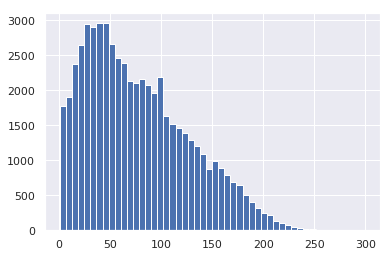

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

seq_lens = [len(s) for s in sequences]
plt.hist([l for l in seq_lens if l < 300], bins=50)

### Padding the vectorized data to bring all the rows into equal length

In [0]:
max_length = 200
data1 = sequence.pad_sequences(sequences,padding='post', maxlen=max_length)

In [0]:
print(len(data1[8]))

200


### To dummify the target variable

In [0]:
from sklearn.preprocessing import OneHotEncoder

In [0]:
from sklearn.preprocessing import LabelEncoder

encoder1 = LabelEncoder()
target1 = encoder1.fit_transform(target)
target1

array([13,  8,  9, ..., 15,  8,  7])

In [0]:
encoder = OneHotEncoder(sparse=False)
target2 = target1.reshape((48667,1))
target3=encoder.fit_transform(target2)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
target3.shape

(48667, 21)

### To split data into train, validation and test

In [0]:
#MEDICATION RELATED,NEW APPOINTMENT,REFILL,OTHERS,SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.),LAB RESULTS,PROVIDER,QUERIES FROM PHARMACY,RESCHEDULING,SHARING OF LAB RECORDS (FAX, E-MAIL, ETC.),PRIOR AUTHORIZATION,SYMPTOMS,CHANGE OF PROVIDER,RUNNING LATE TO APPOINTMENT,CANCELLATION,QUERY ON CURRENT APPOINTMENT,FOLLOW UP ON PREVIOUS REQUEST,CHANGE OF HOSPITAL,QUERIES FROM INSURANCE FIRM,CHANGE OF PHARMACY,JUNK

In [0]:
x_train=data1[0:38932]
x_val=data1[38932:48667]
x_test=data1[48667:]

y_train=target3[0:38932]
y_val=target3[38932:]

In [0]:
print('Shape of labels:', x_train.shape)
print('Shape of labels:', x_val.shape)
print('Shape of labels:', x_test.shape)
print('Shape of labels:', y_train.shape)
print('Shape of labels:', y_val.shape)


Shape of labels: (38932, 200)
Shape of labels: (9735, 200)
Shape of labels: (8581, 200)
Shape of labels: (38932, 21)
Shape of labels: (9735, 21)


In [0]:
inv_index = {v: k for k, v in tokn.word_index.items()}

# Print out text again
for w in x_test[0]:
    x = inv_index.get(w)
    print(x,end = ' ')

request speak give patient refuse give patient appointment go see doctype recommend anti inflammatory help foot pain daughter concerned think pain inflammation thanks nerve pain want know doctor patient take drugname night day make sleepy sleep great night recommend anti inflammatory different meditation cannon woman use antiinflammatories nerve pain well ok trial help great try something else virginia jephro prior authorization daughter told finger response go ahead pick anti inflammatory get start follow north week see cannon woman None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None None 

In [0]:
#plotting result

plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

# Model1: DNN using keras embedding

In [0]:
from keras.models import Sequential
from keras import layers
from keras.layers import Activation, Conv1D, Dense, Embedding, Flatten, Input, MaxPooling1D

embedding_dim = 32

model1 = Sequential()
model1.add(layers.Embedding(input_dim=vocab_Size, 
                           output_dim=embedding_dim, 
                           input_length=max_length))
model1.add(layers.Flatten())
model1.add(layers.Dense(50, activation='relu'))
model1.add(layers.Dense(21, activation='softmax'))
model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model1.summary()


W0808 12:25:38.237622 140702196950912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0808 12:25:38.276288 140702196950912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0808 12:25:38.283312 140702196950912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0808 12:25:38.330658 140702196950912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0808 12:25:38.352186 140702196950912 deprecation_wrappe

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 32)           1222208   
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                320050    
_________________________________________________________________
dense_2 (Dense)              (None, 21)                1071      
Total params: 1,543,329
Trainable params: 1,543,329
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model1.fit(x_train, y_train,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_val, y_val),
                    batch_size=128)
loss, accuracy = model1.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model1.evaluate(x_val, y_val, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))


W0808 12:25:45.215166 140702196950912 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0808 12:25:45.277740 140702196950912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 38932 samples, validate on 9735 samples
Epoch 1/10
38932/38932 [==============================] - 5s 136us/step - loss: 1.5204 - acc: 0.5523 - val_loss: 1.0473 - val_acc: 0.6851
Epoch 2/10
38932/38932 [==============================] - 1s 34us/step - loss: 0.8420 - acc: 0.7379 - val_loss: 0.9055 - val_acc: 0.7180
Epoch 3/10
38932/38932 [==============================] - 1s 33us/step - loss: 0.5977 - acc: 0.8140 - val_loss: 0.9053 - val_acc: 0.7162
Epoch 4/10
38932/38932 [==============================] - 1s 33us/step - loss: 0.4078 - acc: 0.8774 - val_loss: 0.9467 - val_acc: 0.7121
Epoch 5/10
38932/38932 [==============================] - 1s 33us/step - loss: 0.2692 - acc: 0.9251 - val_loss: 1.0296 - val_acc: 0.7049
Epoch 6/10
38932/38932 [==============================] - 1s 33us/step - loss: 0.1758 - acc: 0.9533 - val_loss: 1.1238 - val_acc: 0.7025
Epoch 7/10
38932/38932 [==============================] - 1s 33us/step - loss: 0.1150 - acc: 0.9726 - val_loss: 1.2425 - val_acc

## Train accuracy: 99% ## Validation accuracy: 69%
### Overfitting

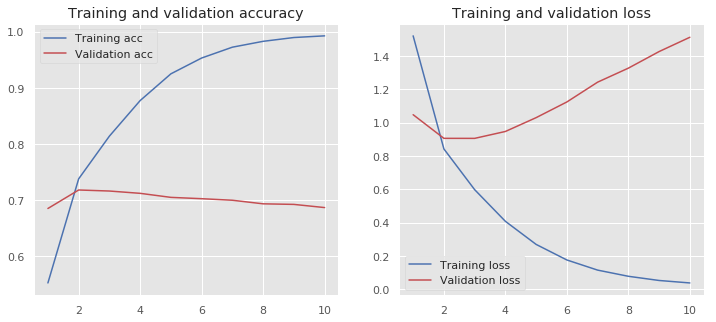

In [0]:
# take epoch between the range of 2-3
plot_history(history)

## Model2: using GlobalMaxPool 1D 
### Accuracy is less

In [0]:
embedding_dim = 32

model2 = Sequential()
model2.add(layers.Embedding(input_dim=vocab_Size, 
                           output_dim=embedding_dim, 
                           input_length=max_length))
model2.add(layers.GlobalMaxPool1D())
#model2.add(Dropout(0.5))
model2.add(layers.Dense(50, activation='relu'))
model2.add(layers.Dense(21, activation='softmax'))
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 32)           1222208   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                1650      
_________________________________________________________________
dense_4 (Dense)              (None, 21)                1071      
Total params: 1,224,929
Trainable params: 1,224,929
Non-trainable params: 0
_________________________________________________________________


In [0]:
history2 = model2.fit(x_train, y_train,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_val, y_val),
                    batch_size=128)
loss, accuracy = model2.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(x_val, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 38932 samples, validate on 9735 samples
Epoch 1/10
38932/38932 [==============================] - 2s 43us/step - loss: 2.2087 - acc: 0.3514 - val_loss: 1.6435 - val_acc: 0.5096
Epoch 2/10
38932/38932 [==============================] - 1s 35us/step - loss: 1.3957 - acc: 0.5830 - val_loss: 1.2380 - val_acc: 0.6197
Epoch 3/10
38932/38932 [==============================] - 1s 33us/step - loss: 1.1102 - acc: 0.6576 - val_loss: 1.0961 - val_acc: 0.6639
Epoch 4/10
38932/38932 [==============================] - 1s 34us/step - loss: 0.9695 - acc: 0.6913 - val_loss: 1.0272 - val_acc: 0.6763
Epoch 5/10
38932/38932 [==============================] - 1s 34us/step - loss: 0.8845 - acc: 0.7142 - val_loss: 0.9936 - val_acc: 0.6837
Epoch 6/10
38932/38932 [==============================] - 1s 33us/step - loss: 0.8243 - acc: 0.7318 - val_loss: 0.9823 - val_acc: 0.6868
Epoch 7/10
38932/38932 [==============================] - 1s 33us/step - loss: 0.7746 - acc: 0.7488 - val_loss: 0.9809 - val_acc:

# Train accu: 80.90% Validation acc: 68.47%

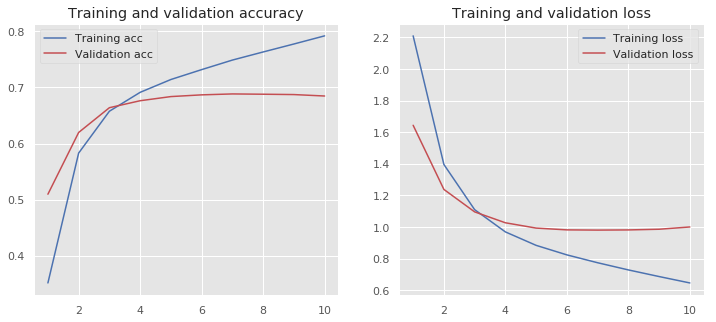

In [0]:
# take epoch between the range of 6-8
plot_history(history2)

# Embedding with word to vec

In [0]:
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_Matrix = np.zeros((vocab_Size, 100))
for word, i in word_Index.items():
    embedding_Vector = embeddings_index.get(word)
    if embedding_Vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_Matrix[i] = embedding_Vector

print (embedding_Matrix.shape)

(38194, 100)


## Model3: Using word to vec embedding(trainable = false) and LSTM

In [0]:
from keras.layers import LSTM, Dense, Activation, Embedding
model3 = Sequential()
model3.add(Embedding(vocab_Size,
                            100,
                            weights=[embedding_Matrix],
                            input_length=max_length,
                            trainable=False))
model3.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(21, activation='softmax'))
model3.summary()

model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

W0808 12:38:13.731578 140702196950912 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 100)          3819400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 21)                2709      
Total params: 3,955,869
Trainable params: 136,469
Non-trainable params: 3,819,400
_________________________________________________________________


In [0]:
# with tf.device('/gpu:0'): 
history3 = model3.fit(x_train, y_train,
                    epochs=28,
                    verbose=1,
                    validation_data=(x_val, y_val),
                    batch_size=128)
loss, accuracy = model3.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model3.evaluate(x_val, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
# sess = tf.Session(config=config)
# sess.run(history3)

Train on 38932 samples, validate on 9735 samples
Epoch 1/28
38932/38932 [==============================] - 99s 3ms/step - loss: 2.3383 - acc: 0.2506 - val_loss: 2.1860 - val_acc: 0.3263
Epoch 2/28
38932/38932 [==============================] - 97s 3ms/step - loss: 2.0801 - acc: 0.3550 - val_loss: 1.8582 - val_acc: 0.4159
Epoch 3/28
38932/38932 [==============================] - 98s 3ms/step - loss: 1.8515 - acc: 0.4285 - val_loss: 1.7040 - val_acc: 0.4884
Epoch 4/28
38932/38932 [==============================] - 98s 3ms/step - loss: 1.7444 - acc: 0.4679 - val_loss: 1.6143 - val_acc: 0.5047
Epoch 5/28
38932/38932 [==============================] - 97s 3ms/step - loss: 1.6573 - acc: 0.4917 - val_loss: 1.5104 - val_acc: 0.5324
Epoch 6/28
38932/38932 [==============================] - 98s 3ms/step - loss: 1.5527 - acc: 0.5197 - val_loss: 1.3672 - val_acc: 0.5752
Epoch 7/28
38932/38932 [==============================] - 98s 3ms/step - loss: 1.4252 - acc: 0.5582 - val_loss: 1.2846 - val_acc:

# Train acc: 73.83% validation accu: 72.37%

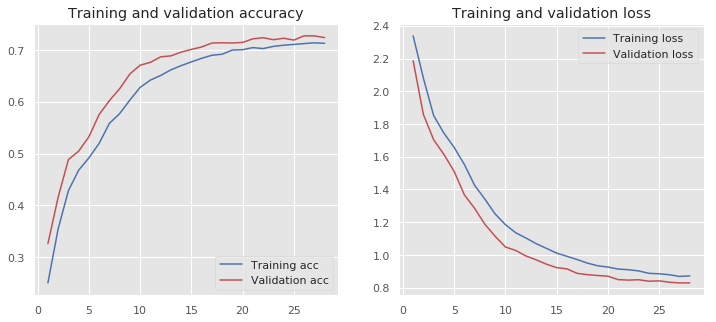

In [0]:
#probably still the model is underfit
plot_history(history3)

# **Using word to vec embedding(trainable = false) and BiDirectional LSTM**

In [0]:
from keras.layers import Bidirectional
from keras.layers import Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU

bi_dir_model = Sequential()
bi_dir_model.add(Embedding(vocab_Size,
                            100,
                            weights=[embedding_Matrix],
                            input_length=max_length,
                            trainable=False))
bi_dir_model.add(Bidirectional(LSTM(128,dropout=0.5,recurrent_dropout=0.5)))
bi_dir_model.add(BatchNormalization())
bi_dir_model.add(Dense(128, activation='relu'))
bi_dir_model.add(Dense(21, activation='softmax'))
bi_dir_model.summary()

bi_dir_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 100)          3819400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               234496    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 21)                2709      
Total params: 4,090,525
Trainable params: 270,613
Non-trainable params: 3,819,912
_________________________________________________________________


In [0]:
import tensorflow as tf

In [51]:
with tf.device('/gpu:0'): 
  bi_dir_history = bi_dir_model.fit(x_train, y_train,
                      epochs=28,
                      verbose=1,
                      validation_data=(x_val, y_val),
                      batch_size=128)
  loss, accuracy = bi_dir_history.evaluate(x_train, y_train, verbose=False)
  print("Training Accuracy: {:.4f}".format(accuracy))
  loss, accuracy = bi_dir_history.evaluate(x_val, y_val, verbose=False)
  print("Validation Accuracy:  {:.4f}".format(accuracy))
sess = tf.Session(config=config)
sess.run(bi_dir_history)

Train on 38932 samples, validate on 9735 samples
Epoch 1/28
38932/38932 [==============================] - 214s 5ms/step - loss: 1.6563 - acc: 0.5077 - val_loss: 1.1395 - val_acc: 0.6563
Epoch 2/28
38932/38932 [==============================] - 213s 5ms/step - loss: 1.1682 - acc: 0.6371 - val_loss: 0.9816 - val_acc: 0.6956
Epoch 3/28
38932/38932 [==============================] - 214s 6ms/step - loss: 1.0285 - acc: 0.6740 - val_loss: 0.9095 - val_acc: 0.7098
Epoch 4/28
38932/38932 [==============================] - 212s 5ms/step - loss: 0.9520 - acc: 0.6921 - val_loss: 0.8806 - val_acc: 0.7205
Epoch 5/28
38932/38932 [==============================] - 213s 5ms/step - loss: 0.9085 - acc: 0.7044 - val_loss: 0.8526 - val_acc: 0.7219
Epoch 6/28
38932/38932 [==============================] - 214s 5ms/step - loss: 0.8784 - acc: 0.7100 - val_loss: 0.8230 - val_acc: 0.7288
Epoch 7/28
38932/38932 [==============================] - 214s 5ms/step - loss: 0.8476 - acc: 0.7187 - val_loss: 0.8194 - v

AttributeError: ignored

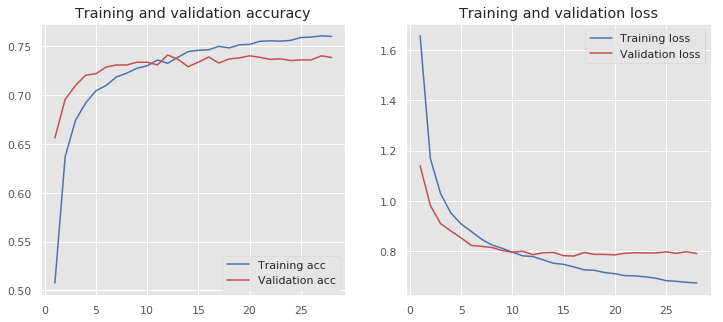

In [52]:
# number of epochs should be 19-20
plot_history(bi_dir_history)

#### Train acc: 76.02% validation accu: 73.86%

## Model4: DNN Worde2vec embedding model

In [54]:
model4 = Sequential()
model4.add(Embedding(vocab_Size,
                            100,
                            weights=[embedding_Matrix],
                            input_length=max_length,
                            trainable=False))
model4.add(layers.Flatten())
model4.add(layers.Dense(50, activation='relu'))
model4.add(layers.Dense(21, activation='softmax'))
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 100)          3819400   
_________________________________________________________________
flatten_2 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                1000050   
_________________________________________________________________
dense_10 (Dense)             (None, 21)                1071      
Total params: 4,820,521
Trainable params: 1,001,121
Non-trainable params: 3,819,400
_________________________________________________________________


In [55]:
# with tf.device('/gpu:0'):  
history4 = model4.fit(x_train, y_train,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_val, y_val),
                    batch_size=128)
loss, accuracy = model4.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model4.evaluate(x_val, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
# sess = tf.Session(config=config)
# sess.run(history4)

Train on 38932 samples, validate on 9735 samples
Epoch 1/10
38932/38932 [==============================] - 2s 51us/step - loss: 1.5077 - acc: 0.5558 - val_loss: 1.2600 - val_acc: 0.6219
Epoch 2/10
38932/38932 [==============================] - 1s 31us/step - loss: 0.9359 - acc: 0.7058 - val_loss: 1.2174 - val_acc: 0.6326
Epoch 3/10
38932/38932 [==============================] - 1s 30us/step - loss: 0.6643 - acc: 0.7887 - val_loss: 1.2896 - val_acc: 0.6231
Epoch 4/10
38932/38932 [==============================] - 1s 30us/step - loss: 0.4705 - acc: 0.8552 - val_loss: 1.3996 - val_acc: 0.6198
Epoch 5/10
38932/38932 [==============================] - 1s 31us/step - loss: 0.3320 - acc: 0.9025 - val_loss: 1.4830 - val_acc: 0.6223
Epoch 6/10
38932/38932 [==============================] - 1s 30us/step - loss: 0.2339 - acc: 0.9361 - val_loss: 1.6302 - val_acc: 0.6164
Epoch 7/10
38932/38932 [==============================] - 1s 30us/step - loss: 0.1655 - acc: 0.9591 - val_loss: 1.7757 - val_acc:

## Train acc: 99.57% Validation acc: 61.45% 
### Overfitting

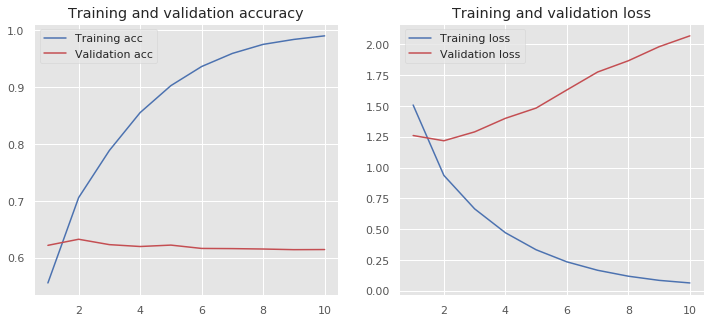

In [57]:
# too much overfit
# number of epochs should 1-2 or probably use batchnormalization()
plot_history(history4)

# Model5: word2vec and GlobalMaxPool1D

In [58]:
model5 = Sequential()
model5.add(Embedding(vocab_Size,
                            100,
                            weights=[embedding_Matrix],
                            input_length=max_length,
                            trainable=False))
model5.add(layers.GlobalMaxPool1D())
model5.add(layers.Dense(50, activation='relu'))
model5.add(layers.Dense(21, activation='softmax'))
model5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 100)          3819400   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_12 (Dense)             (None, 21)                1071      
Total params: 3,825,521
Trainable params: 6,121
Non-trainable params: 3,819,400
_________________________________________________________________


In [60]:
# with tf.device('/gpu:0'):  
history5 = model5.fit(x_train, y_train,
                    epochs=50,
                    verbose=1,
                    validation_data=(x_val, y_val),
                    batch_size=128)
loss, accuracy = model5.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model5.evaluate(x_val, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 38932 samples, validate on 9735 samples
Epoch 1/50
38932/38932 [==============================] - 1s 29us/step - loss: 1.2139 - acc: 0.6075 - val_loss: 1.2422 - val_acc: 0.5969
Epoch 2/50
38932/38932 [==============================] - 1s 29us/step - loss: 1.2104 - acc: 0.6084 - val_loss: 1.2488 - val_acc: 0.5926
Epoch 3/50
38932/38932 [==============================] - 1s 26us/step - loss: 1.2085 - acc: 0.6090 - val_loss: 1.2608 - val_acc: 0.5901
Epoch 4/50
38932/38932 [==============================] - 1s 25us/step - loss: 1.2091 - acc: 0.6097 - val_loss: 1.2489 - val_acc: 0.5919
Epoch 5/50
38932/38932 [==============================] - 1s 25us/step - loss: 1.2090 - acc: 0.6077 - val_loss: 1.2576 - val_acc: 0.5922
Epoch 6/50
38932/38932 [==============================] - 1s 26us/step - loss: 1.2055 - acc: 0.6078 - val_loss: 1.2495 - val_acc: 0.5917
Epoch 7/50
38932/38932 [==============================] - 1s 25us/step - loss: 1.2033 - acc: 0.6115 - val_loss: 1.2525 - val_acc:

## Train acc: 62.33% # Validation acc: 59.82%

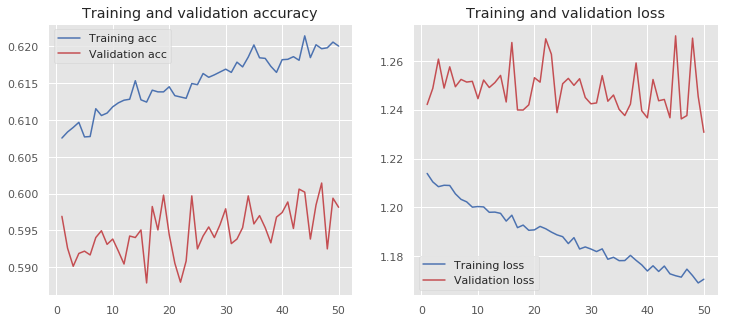

In [61]:
plot_history(history5)

# Model6: 1D convolution and Maxpooling

In [62]:
from keras.layers import Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
model6 = Sequential()
model6.add(Embedding(vocab_Size,
                            100,
                            weights=[embedding_Matrix],
                            input_length=max_length,
                            trainable=False))
model6.add(Conv1D(128, 3, activation='linear'))
model6.add(LeakyReLU(alpha=.009))
model6.add(MaxPooling1D(3))
model6.add(Dropout(0.3))
model6.add(BatchNormalization())
model6.add(Conv1D(128, 3, activation='linear'))
model6.add(LeakyReLU(alpha=.009))
model6.add(MaxPooling1D(3))
model6.add(Dropout(0.3))
model6.add(BatchNormalization())
model6.add(Conv1D(128, 3, activation='linear'))
model6.add(LeakyReLU(alpha=.009))
model6.add(MaxPooling1D(3))
model6.add(Dropout(0.3))
model6.add(BatchNormalization())
model6.add(Dense(128, activation='linear'))
model6.add(LeakyReLU(alpha=.009))
#model6.add(Dropout(0.2))
model6.add(BatchNormalization())
model6.add(Dense(128, activation='linear'))
model6.add(LeakyReLU(alpha=.009))
#model6.add(Dropout(0.2))
model6.add(BatchNormalization())
model6.add(Flatten())
model6.add(Dense(21, activation='softmax'))
model6.summary()

model6.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

W0808 15:53:54.179891 140702196950912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 200, 100)          3819400   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 198, 128)          38528     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 198, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 66, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 66, 128)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 66, 128)           512       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 64, 128)           49280     
__________

In [63]:
# with tf.device('/gpu:0'):  
history6 = model6.fit(x_train, y_train,
                    epochs=20,
                    verbose=1,
                    validation_data=(x_val, y_val),
                    batch_size=128)
loss, accuracy = model6.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model6.evaluate(x_val, y_val, verbose=False)
print("Validation Accuracy:{:.4f}".format(accuracy))

Train on 38932 samples, validate on 9735 samples
Epoch 1/20
38932/38932 [==============================] - 10s 261us/step - loss: 1.8821 - acc: 0.4438 - val_loss: 1.9249 - val_acc: 0.4297
Epoch 2/20
38932/38932 [==============================] - 4s 113us/step - loss: 1.3064 - acc: 0.5993 - val_loss: 1.2242 - val_acc: 0.6185
Epoch 3/20
38932/38932 [==============================] - 4s 113us/step - loss: 1.1349 - acc: 0.6465 - val_loss: 1.1613 - val_acc: 0.6353
Epoch 4/20
38932/38932 [==============================] - 4s 112us/step - loss: 1.0347 - acc: 0.6749 - val_loss: 0.9812 - val_acc: 0.6899
Epoch 5/20
38932/38932 [==============================] - 4s 113us/step - loss: 0.9709 - acc: 0.6920 - val_loss: 0.9807 - val_acc: 0.6879
Epoch 6/20
38932/38932 [==============================] - 4s 114us/step - loss: 0.9321 - acc: 0.6993 - val_loss: 0.9565 - val_acc: 0.6933
Epoch 7/20
38932/38932 [==============================] - 4s 113us/step - loss: 0.8977 - acc: 0.7082 - val_loss: 0.9283 - 

## Train acc: 80.73% Validation acc: 72.11 % 
### Overfitting

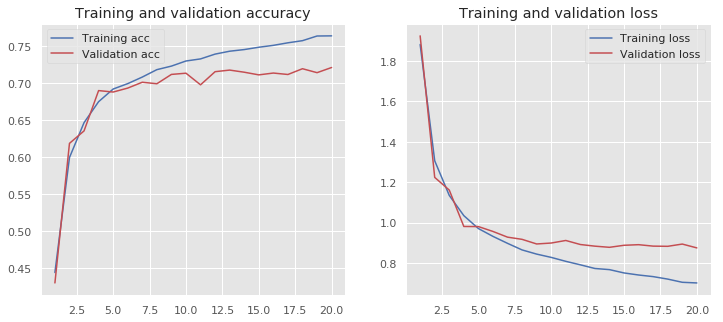

In [64]:
# number of epochs should be between 12-15
plot_history(history6)

## Model7: Convolution and LSTM 

In [65]:
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dropout
from keras.models import Model

embedding_layer = Embedding(vocab_Size,
                            100,
                            weights=[embedding_Matrix],
                            input_length=max_length,
                            trainable=False)
sequence_input = Input(shape=(max_length,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

# 1D convolution with 64 output channels
x = Conv1D(64, 5)(embedded_sequences)
# MaxPool divides the length of the sequence by 5
x = MaxPooling1D(5)(x)
x = Dropout(0.5)(x)
x = Conv1D(64, 5)(x)
x = MaxPooling1D(5)(x)
# LSTM layer with a hidden size of 64
x = Dropout(0.5)(x)
x = LSTM(64,dropout=0.5)(x)
predictions = Dense(21, activation='softmax')(x)

model7 = Model(sequence_input, predictions)
model7.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model7.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 200, 100)          3819400   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 196, 64)           32064     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 39, 64)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 39, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 35, 64)            20544     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 7, 64)             0         
__________

In [66]:
history7 = model7.fit(x_train, y_train,
                    epochs=15,
                    verbose=1,
                    validation_data=(x_val, y_val),
                    batch_size=128)
loss, accuracy = model7.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model7.evaluate(x_val, y_val, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))

Train on 38932 samples, validate on 9735 samples
Epoch 1/15
38932/38932 [==============================] - 8s 215us/step - loss: 2.0543 - acc: 0.3836 - val_loss: 1.6909 - val_acc: 0.4827
Epoch 2/15
38932/38932 [==============================] - 6s 144us/step - loss: 1.6411 - acc: 0.4990 - val_loss: 1.4914 - val_acc: 0.5463
Epoch 3/15
38932/38932 [==============================] - 6s 145us/step - loss: 1.4949 - acc: 0.5333 - val_loss: 1.3142 - val_acc: 0.5869
Epoch 4/15
38932/38932 [==============================] - 6s 146us/step - loss: 1.3921 - acc: 0.5632 - val_loss: 1.3184 - val_acc: 0.5940
Epoch 5/15
38932/38932 [==============================] - 6s 146us/step - loss: 1.3221 - acc: 0.5835 - val_loss: 1.1829 - val_acc: 0.6319
Epoch 6/15
38932/38932 [==============================] - 6s 145us/step - loss: 1.2724 - acc: 0.5995 - val_loss: 1.1297 - val_acc: 0.6478
Epoch 7/15
38932/38932 [==============================] - 6s 144us/step - loss: 1.2378 - acc: 0.6087 - val_loss: 1.1079 - v

# Train acc: 71.69% validation acc: 69.30%

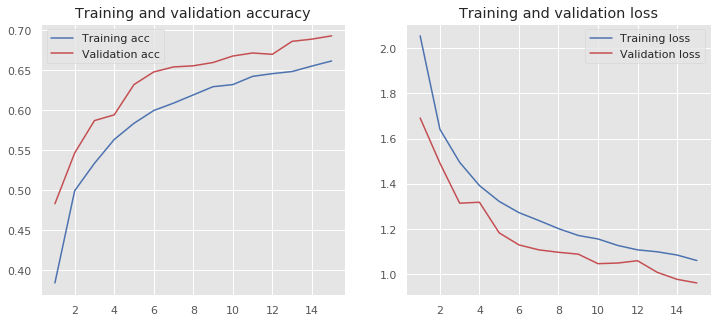

In [67]:
# probably the model is underfit
plot_history(history7)

# Model3a: word2vec(trainable = false) and LSTM

In [68]:
from keras.layers import LSTM, Dense, Activation, Embedding
model3a = Sequential()
model3a.add(Embedding(vocab_Size,
                            100,
                            weights=[embedding_Matrix],
                            input_length=max_length,
                            trainable=True))
model3a.add(LSTM(128,dropout=0.5, recurrent_dropout=0.2))
model3a.add(Dense(128, activation='relu'))
model3a.add(Dense(21, activation='softmax'))
model3a.summary()

model3a.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 200, 100)          3819400   
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_17 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_18 (Dense)             (None, 21)                2709      
Total params: 3,955,869
Trainable params: 3,955,869
Non-trainable params: 0
_________________________________________________________________


In [69]:
history3a = model3a.fit(x_train, y_train,
                    epochs=30,
                    verbose=1,
                    validation_data=(x_val, y_val),
                    batch_size=128)


Train on 38932 samples, validate on 9735 samples
Epoch 1/30
38932/38932 [==============================] - 110s 3ms/step - loss: 2.2757 - acc: 0.2841 - val_loss: 1.9972 - val_acc: 0.3823
Epoch 2/30
38932/38932 [==============================] - 108s 3ms/step - loss: 1.8956 - acc: 0.4159 - val_loss: 1.6998 - val_acc: 0.5008
Epoch 3/30
38932/38932 [==============================] - 108s 3ms/step - loss: 1.6293 - acc: 0.5007 - val_loss: 1.4666 - val_acc: 0.5490
Epoch 4/30
38932/38932 [==============================] - 107s 3ms/step - loss: 1.4008 - acc: 0.5711 - val_loss: 1.2547 - val_acc: 0.6215
Epoch 5/30
38932/38932 [==============================] - 107s 3ms/step - loss: 1.2471 - acc: 0.6183 - val_loss: 1.1550 - val_acc: 0.6367
Epoch 6/30
38932/38932 [==============================] - 108s 3ms/step - loss: 1.1295 - acc: 0.6469 - val_loss: 1.0484 - val_acc: 0.6731
Epoch 7/30
38932/38932 [==============================] - 107s 3ms/step - loss: 1.0218 - acc: 0.6765 - val_loss: 0.9474 - v

In [70]:
loss, accuracy = model3a.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model3a.evaluate(x_val, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9077
Testing Accuracy:  0.7217


# Train acc: 90.77% validation acc: 72.17%

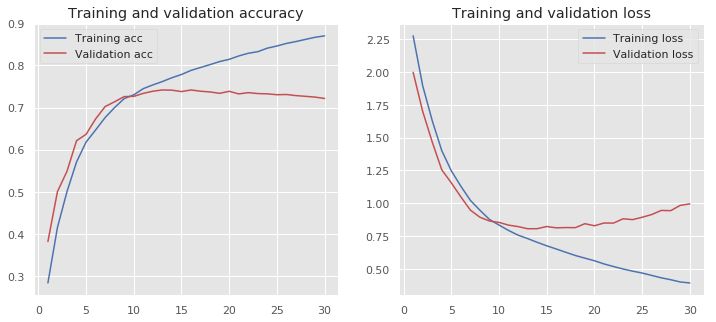

In [71]:
# number of epochs should be 9-10
plot_history(history3a)

In [72]:
model4a = Sequential()
model4a.add(Embedding(vocab_Size,
                            100,
                            weights=[embedding_Matrix],
                            input_length=max_length,
                            trainable=True))
model4a.add(layers.Flatten())
model4a.add(layers.Dense(50, activation='relu'))
model4a.add(layers.Dense(21, activation='softmax'))
model4a.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model4a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 200, 100)          3819400   
_________________________________________________________________
flatten_4 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 50)                1000050   
_________________________________________________________________
dense_20 (Dense)             (None, 21)                1071      
Total params: 4,820,521
Trainable params: 4,820,521
Non-trainable params: 0
_________________________________________________________________


In [73]:
history4a = model4a.fit(x_train, y_train,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_val, y_val),
                    batch_size=128)
loss, accuracy = model4a.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model4a.evaluate(x_val, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 38932 samples, validate on 9735 samples
Epoch 1/10
38932/38932 [==============================] - 4s 102us/step - loss: 1.3985 - acc: 0.5824 - val_loss: 1.1018 - val_acc: 0.6588
Epoch 2/10
38932/38932 [==============================] - 2s 56us/step - loss: 0.7462 - acc: 0.7629 - val_loss: 1.0443 - val_acc: 0.6815
Epoch 3/10
38932/38932 [==============================] - 2s 56us/step - loss: 0.4318 - acc: 0.8650 - val_loss: 1.1333 - val_acc: 0.6782
Epoch 4/10
38932/38932 [==============================] - 2s 56us/step - loss: 0.2312 - acc: 0.9351 - val_loss: 1.2394 - val_acc: 0.6784
Epoch 5/10
38932/38932 [==============================] - 2s 56us/step - loss: 0.1144 - acc: 0.9740 - val_loss: 1.3874 - val_acc: 0.6727
Epoch 6/10
38932/38932 [==============================] - 2s 56us/step - loss: 0.0607 - acc: 0.9888 - val_loss: 1.4773 - val_acc: 0.6748
Epoch 7/10
38932/38932 [==============================] - 2s 56us/step - loss: 0.0378 - acc: 0.9933 - val_loss: 1.5777 - val_acc

### Training Accuracy: 99.65% Validation accuracy:67.30%

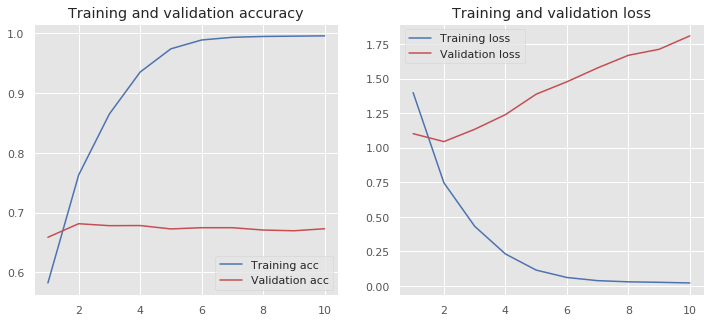

In [74]:
# number of epochs should be in the range of 1-2
plot_history(history4a)

In [75]:
model5a = Sequential()
model5a.add(Embedding(vocab_Size,
                            100,
                            weights=[embedding_Matrix],
                            input_length=max_length,
                            trainable=False))
model5a.add(layers.GlobalMaxPool1D())
model5a.add(layers.Dense(50, activation='relu'))
model5a.add(layers.Dense(21, activation='softmax'))
model5a.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model5a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 200, 100)          3819400   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_22 (Dense)             (None, 21)                1071      
Total params: 3,825,521
Trainable params: 6,121
Non-trainable params: 3,819,400
_________________________________________________________________


In [76]:
history5a = model5a.fit(x_train, y_train,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_val, y_val),
                    batch_size=128)
loss, accuracy = model5a.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model5a.evaluate(x_val, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 38932 samples, validate on 9735 samples
Epoch 1/10
38932/38932 [==============================] - 3s 70us/step - loss: 2.1502 - acc: 0.3723 - val_loss: 1.8704 - val_acc: 0.4571
Epoch 2/10
38932/38932 [==============================] - 1s 27us/step - loss: 1.7517 - acc: 0.4750 - val_loss: 1.6626 - val_acc: 0.4912
Epoch 3/10
38932/38932 [==============================] - 1s 28us/step - loss: 1.6106 - acc: 0.5025 - val_loss: 1.5943 - val_acc: 0.5136
Epoch 4/10
38932/38932 [==============================] - 1s 27us/step - loss: 1.5265 - acc: 0.5247 - val_loss: 1.4913 - val_acc: 0.5319
Epoch 5/10
38932/38932 [==============================] - 1s 27us/step - loss: 1.4716 - acc: 0.5380 - val_loss: 1.4710 - val_acc: 0.5315
Epoch 6/10
38932/38932 [==============================] - 1s 27us/step - loss: 1.4290 - acc: 0.5502 - val_loss: 1.4307 - val_acc: 0.5460
Epoch 7/10
38932/38932 [==============================] - 1s 27us/step - loss: 1.4009 - acc: 0.5569 - val_loss: 1.3994 - val_acc:

### Training Accuracy: 57.67% Validation Accuracy: 57.29%

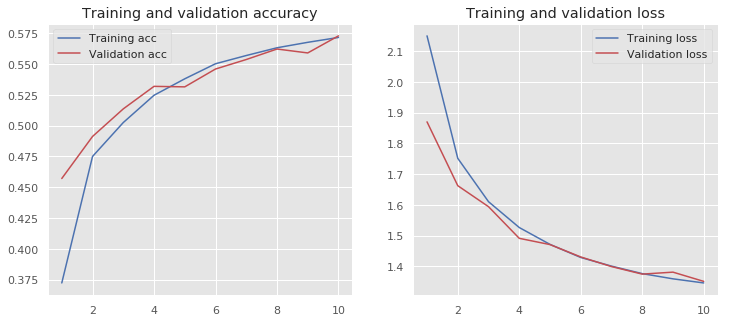

In [77]:
# probably the model is underfit
plot_history(history5a)

# Model 6a: word2vec (train is true) and Convolution 1D 

In [78]:
model6a = Sequential()
model6a.add(Embedding(vocab_Size,
                            100,
                            weights=[embedding_Matrix],
                            input_length=max_length,
                            trainable=True))
model6a.add(Conv1D(128, 3, activation='relu'))
model6a.add(MaxPooling1D(3))
model6a.add(Conv1D(128, 3, activation='relu'))
model6a.add(MaxPooling1D(3))
model6a.add(Conv1D(128, 3, activation='relu'))
model6a.add(MaxPooling1D(3))
model6a.add(Flatten())
model6a.add(Dense(128, activation='relu'))
model6a.add(Dense(21, activation='softmax'))
model6a.summary()

model6a.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 200, 100)          3819400   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 198, 128)          38528     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 66, 128)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 64, 128)           49280     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 21, 128)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 19, 128)           49280     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 6, 128)            0         
__________

In [79]:
history6a = model6a.fit(x_train, y_train,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_val, y_val),
                    batch_size=128)
loss, accuracy = model6a.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model6a.evaluate(x_val, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 38932 samples, validate on 9735 samples
Epoch 1/10
38932/38932 [==============================] - 6s 154us/step - loss: 1.4993 - acc: 0.5466 - val_loss: 1.0888 - val_acc: 0.6606
Epoch 2/10
38932/38932 [==============================] - 4s 96us/step - loss: 0.9485 - acc: 0.6986 - val_loss: 0.9512 - val_acc: 0.6976
Epoch 3/10
38932/38932 [==============================] - 4s 96us/step - loss: 0.7831 - acc: 0.7437 - val_loss: 0.8720 - val_acc: 0.7207
Epoch 4/10
38932/38932 [==============================] - 4s 95us/step - loss: 0.6623 - acc: 0.7817 - val_loss: 0.9079 - val_acc: 0.7203
Epoch 5/10
38932/38932 [==============================] - 4s 96us/step - loss: 0.5456 - acc: 0.8183 - val_loss: 0.9056 - val_acc: 0.7192
Epoch 6/10
38932/38932 [==============================] - 4s 97us/step - loss: 0.4231 - acc: 0.8615 - val_loss: 1.0340 - val_acc: 0.7088
Epoch 7/10
38932/38932 [==============================] - 4s 95us/step - loss: 0.2986 - acc: 0.9032 - val_loss: 1.1991 - val_acc

# Train acc: 98.63% Val acc: 69.78%
### Overfitting

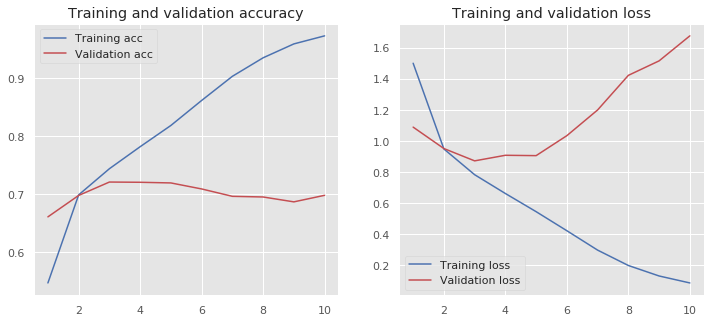

In [80]:
# number of epoch should be 2-3
plot_history(history6a)

# Model 7a: word2vec  trainable is TRUE and convolution 1D and LSTM

In [81]:
embedding_layer = Embedding(vocab_Size,
                            100,
                            weights=[embedding_Matrix],
                            input_length=max_length,
                            trainable=True)
sequence_input = Input(shape=(max_length,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

# 1D convolution with 64 output channels
x = Conv1D(64, 5)(embedded_sequences)
# MaxPool divides the length of the sequence by 5
x = MaxPooling1D(5)(x)
x = Dropout(0.5)(x)
x = Conv1D(64, 5)(x)
x = MaxPooling1D(5)(x)
# LSTM layer with a hidden size of 64
x = Dropout(0.5)(x)
x = LSTM(64,dropout=0.5)(x)
predictions = Dense(21, activation='softmax')(x)

model7a = Model(sequence_input, predictions)
model7a.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model7a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 200, 100)          3819400   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 196, 64)           32064     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 39, 64)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 39, 64)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 35, 64)            20544     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 7, 64)             0         
__________

In [82]:
history7a = model7a.fit(x_train, y_train,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_val, y_val),
                    batch_size=128)
loss, accuracy = model7a.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model7a.evaluate(x_val, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 38932 samples, validate on 9735 samples
Epoch 1/10
38932/38932 [==============================] - 10s 246us/step - loss: 2.0081 - acc: 0.3901 - val_loss: 1.6536 - val_acc: 0.4942
Epoch 2/10
38932/38932 [==============================] - 7s 169us/step - loss: 1.5697 - acc: 0.5144 - val_loss: 1.3524 - val_acc: 0.5850
Epoch 3/10
38932/38932 [==============================] - 7s 168us/step - loss: 1.3553 - acc: 0.5748 - val_loss: 1.2251 - val_acc: 0.6153
Epoch 4/10
38932/38932 [==============================] - 7s 169us/step - loss: 1.2397 - acc: 0.6096 - val_loss: 1.1478 - val_acc: 0.6442
Epoch 5/10
38932/38932 [==============================] - 7s 169us/step - loss: 1.1636 - acc: 0.6323 - val_loss: 1.1374 - val_acc: 0.6535
Epoch 6/10
38932/38932 [==============================] - 7s 170us/step - loss: 1.1020 - acc: 0.6509 - val_loss: 1.0831 - val_acc: 0.6614
Epoch 7/10
38932/38932 [==============================] - 7s 170us/step - loss: 1.0517 - acc: 0.6679 - val_loss: 1.0344 - 

###  Training Accuracy: 76.46% Validation Accuracy: 68.32%

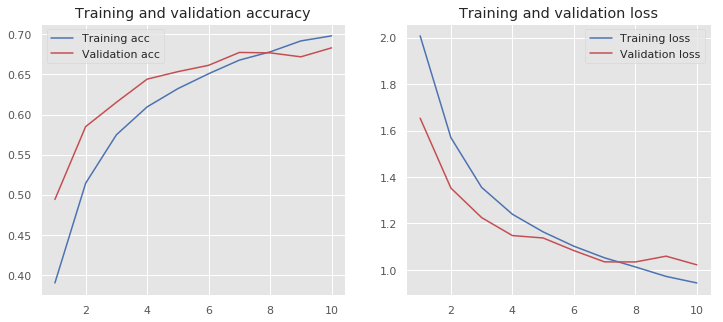

In [83]:
# probably the model is underfit
plot_history(history7a)

# Prediction on test dataset

## Data Exploration

In [84]:
test_rawdata.head()

,id,converse
0,1,request speak give patient refuse give patient...
1,2,patient husband met name spouse patient husban...
2,3,foi mon appointment next timephrase mon want r...
3,4,refill drugname pharmacy name reason call deta...
4,5,need time test dad request letter state patien...


In [0]:
test_texts=test_rawdata["converse"].astype('str')

In [0]:
test_sequences = tokn.texts_to_sequences(test_texts)

In [87]:
print (len(test_sequences))
print (len(test_sequences[0]))
print (test_sequences[0])

8581
78
[65, 270, 88, 4, 2938, 88, 4, 24, 160, 77, 183, 675, 2284, 5960, 315, 1214, 81, 221, 585, 492, 81, 3573, 213, 790, 81, 182, 79, 42, 4, 85, 10, 305, 107, 262, 1551, 165, 1131, 305, 675, 2284, 5960, 695, 190, 3566, 2522, 279, 17219, 790, 81, 268, 140, 1393, 315, 1131, 231, 495, 697, 571, 2055, 87, 106, 221, 174, 3364, 616, 160, 970, 241, 2284, 5960, 104, 304, 22, 951, 150, 77, 3566, 2522]


In [88]:
print(test_texts[0], test_sequences[0])

request speak give patient refuse give patient appointment go see doctype recommend anti inflammatory help foot pain daughter concerned think pain inflammation thanks nerve pain want know doctor patient take drugname night day make sleepy sleep great night recommend anti inflammatory different meditation cannon woman use antiinflammatories nerve pain well ok trial help great try something else virginia jephro prior authorization daughter told finger response go ahead pick anti inflammatory get start follow north week see cannon woman [65, 270, 88, 4, 2938, 88, 4, 24, 160, 77, 183, 675, 2284, 5960, 315, 1214, 81, 221, 585, 492, 81, 3573, 213, 790, 81, 182, 79, 42, 4, 85, 10, 305, 107, 262, 1551, 165, 1131, 305, 675, 2284, 5960, 695, 190, 3566, 2522, 279, 17219, 790, 81, 268, 140, 1393, 315, 1131, 231, 495, 697, 571, 2055, 87, 106, 221, 174, 3364, 616, 160, 970, 241, 2284, 5960, 104, 304, 22, 951, 150, 77, 3566, 2522]


In [89]:
avg2 = sum(map(len, test_sequences)) / len(test_sequences)

# Get the standard deviation of the sequence length
std2 = np.sqrt(sum(map(lambda x: (len(x) - avg2)**2, test_sequences)) / len(test_sequences))

avg2,std2

(50.95163733830556, 30.617867088480015)

In [0]:
data2 = sequence.pad_sequences(test_sequences, maxlen=max_length)

In [91]:
data2

array([[   0,    0,    0, ...,   77, 3566, 2522],
       [   0,    0,    0, ...,   22,   62,    7],
       [   0,    0,    0, ...,  186,  778,  229],
       ...,
       [   0,    0,    0, ...,   43,   47,  139],
       [   0,    0,    0, ...,   69,  252, 1021],
       [   0,    0,    0, ...,  228,    7,   23]], dtype=int32)

# Model prediction on test

In [92]:
Y_pred = model6.predict(x_test)
print(Y_pred[5])

[2.3037073e-04 1.6745050e-03 2.1269694e-03 1.1438725e-02 1.0551493e-02
 2.4475372e-05 4.5065382e-03 7.7992421e-01 1.1276508e-03 1.1376716e-01
 3.9041585e-03 1.4026990e-03 4.6454199e-05 3.3064338e-04 8.6960982e-04
 4.4965237e-02 2.0024559e-04 1.9187716e-04 1.9876402e-02 2.2106395e-04
 2.6195052e-03]


In [93]:
y_pred =[]
for i in Y_pred:
    y_pred.append(np.argmax(i))

print(y_pred)

[7, 9, 7, 15, 18, 7, 9, 8, 8, 11, 8, 8, 6, 6, 9, 15, 15, 11, 6, 8, 9, 9, 7, 9, 19, 8, 15, 18, 16, 7, 9, 20, 18, 18, 9, 7, 10, 8, 15, 9, 20, 9, 18, 7, 15, 7, 8, 11, 9, 9, 10, 20, 9, 15, 15, 7, 9, 8, 9, 7, 8, 15, 9, 3, 7, 9, 8, 7, 9, 18, 7, 0, 15, 16, 18, 7, 8, 8, 6, 8, 7, 9, 7, 7, 9, 9, 7, 9, 15, 11, 14, 18, 17, 7, 15, 8, 7, 8, 8, 7, 18, 15, 8, 15, 13, 15, 11, 15, 9, 8, 9, 9, 9, 9, 3, 15, 9, 9, 8, 10, 8, 9, 7, 8, 8, 8, 6, 8, 7, 15, 9, 9, 9, 3, 15, 9, 8, 17, 3, 7, 8, 18, 7, 11, 18, 9, 8, 15, 17, 9, 9, 9, 15, 15, 7, 9, 15, 15, 7, 9, 9, 15, 9, 3, 9, 18, 15, 11, 8, 18, 8, 9, 18, 3, 11, 11, 9, 8, 9, 8, 8, 8, 15, 20, 9, 9, 8, 7, 7, 7, 9, 8, 9, 7, 7, 7, 20, 9, 9, 16, 7, 15, 8, 8, 7, 6, 18, 6, 7, 9, 15, 6, 9, 8, 18, 7, 8, 15, 8, 6, 13, 9, 15, 3, 6, 9, 11, 9, 7, 9, 11, 9, 8, 9, 7, 9, 7, 8, 15, 15, 7, 15, 9, 11, 6, 15, 9, 7, 10, 9, 15, 15, 9, 8, 14, 8, 9, 7, 7, 7, 8, 9, 15, 9, 11, 17, 8, 7, 15, 7, 9, 9, 7, 9, 9, 18, 9, 6, 15, 8, 8, 8, 7, 9, 11, 9, 15, 8, 7, 6, 7, 15, 11, 15, 7, 11, 9, 18, 9, 7, 7

In [0]:
#y_pred1=pd.DataFrame(y_pred)

In [0]:
test_out=encoder1.inverse_transform(y_pred)

In [0]:
test_output=pd.DataFrame(test_out)

# Export of output

In [0]:
test_output.to_csv('CNNoutput.csv', index = 'categories')